In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
students_data = pd.read_csv("Date_curatate_Calin.csv")
students_data.head(), students_data.info(), students_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131258 entries, 0 to 131257
Data columns (total 27 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   Unnamed: 0                                    131258 non-null  int64  
 1   Cod unic candidat                             131258 non-null  int64  
 2   Sex                                           131258 non-null  object 
 3   Specializare                                  131258 non-null  object 
 4   Profil                                        131258 non-null  object 
 5   Fileira                                       131258 non-null  object 
 6   Forma de învățământ                           131258 non-null  object 
 7   Mediu candidat                                131258 non-null  object 
 8   Unitate (SIIIR)                               131258 non-null  int64  
 9   STATUS                                        13

(   Unnamed: 0  Cod unic candidat Sex               Specializare    Profil  \
 0           0              10005   M  TEHNICIAN_IN_AUTOMATIZARI    TEHNIC   
 1           1              12037   M            STIINTE_SOCIALE      UMAN   
 2           2              12284   M        TEHNICIAN_IN_TURISM  SERVICII   
 3           3              12865   F                  FILOLOGIE      UMAN   
 4           4              12923   F     ORGANIZATOR_BANQUETING  SERVICII   
 
        Fileira Forma de învățământ Mediu candidat  Unitate (SIIIR)  \
 0  TEHNOLOGICA                  ZI          URBAN       3261101959   
 1    TEORETICA    FRECVENTA_REDUSA          URBAN       3661100016   
 2  TEHNOLOGICA                  ZI          URBAN       1161104376   
 3    TEORETICA                  ZI          URBAN        961100082   
 4  TEHNOLOGICA                  ZI          RURAL       2461103282   
 
        STATUS  ...           locality runningWater canalization gas  \
 0  NEPROMOVAT  ...           

# Variables selection

### As we want to model the **(student's average score Medie)** based on the data we have available (school facilities, demographics and environmental factors, educational characteristics), my go-to is selecting some of the factors I consider relevant (as concluded from the exploratory analyses my colleagues previously conducted) and plotting them to visually analyse and select the more relevant factors

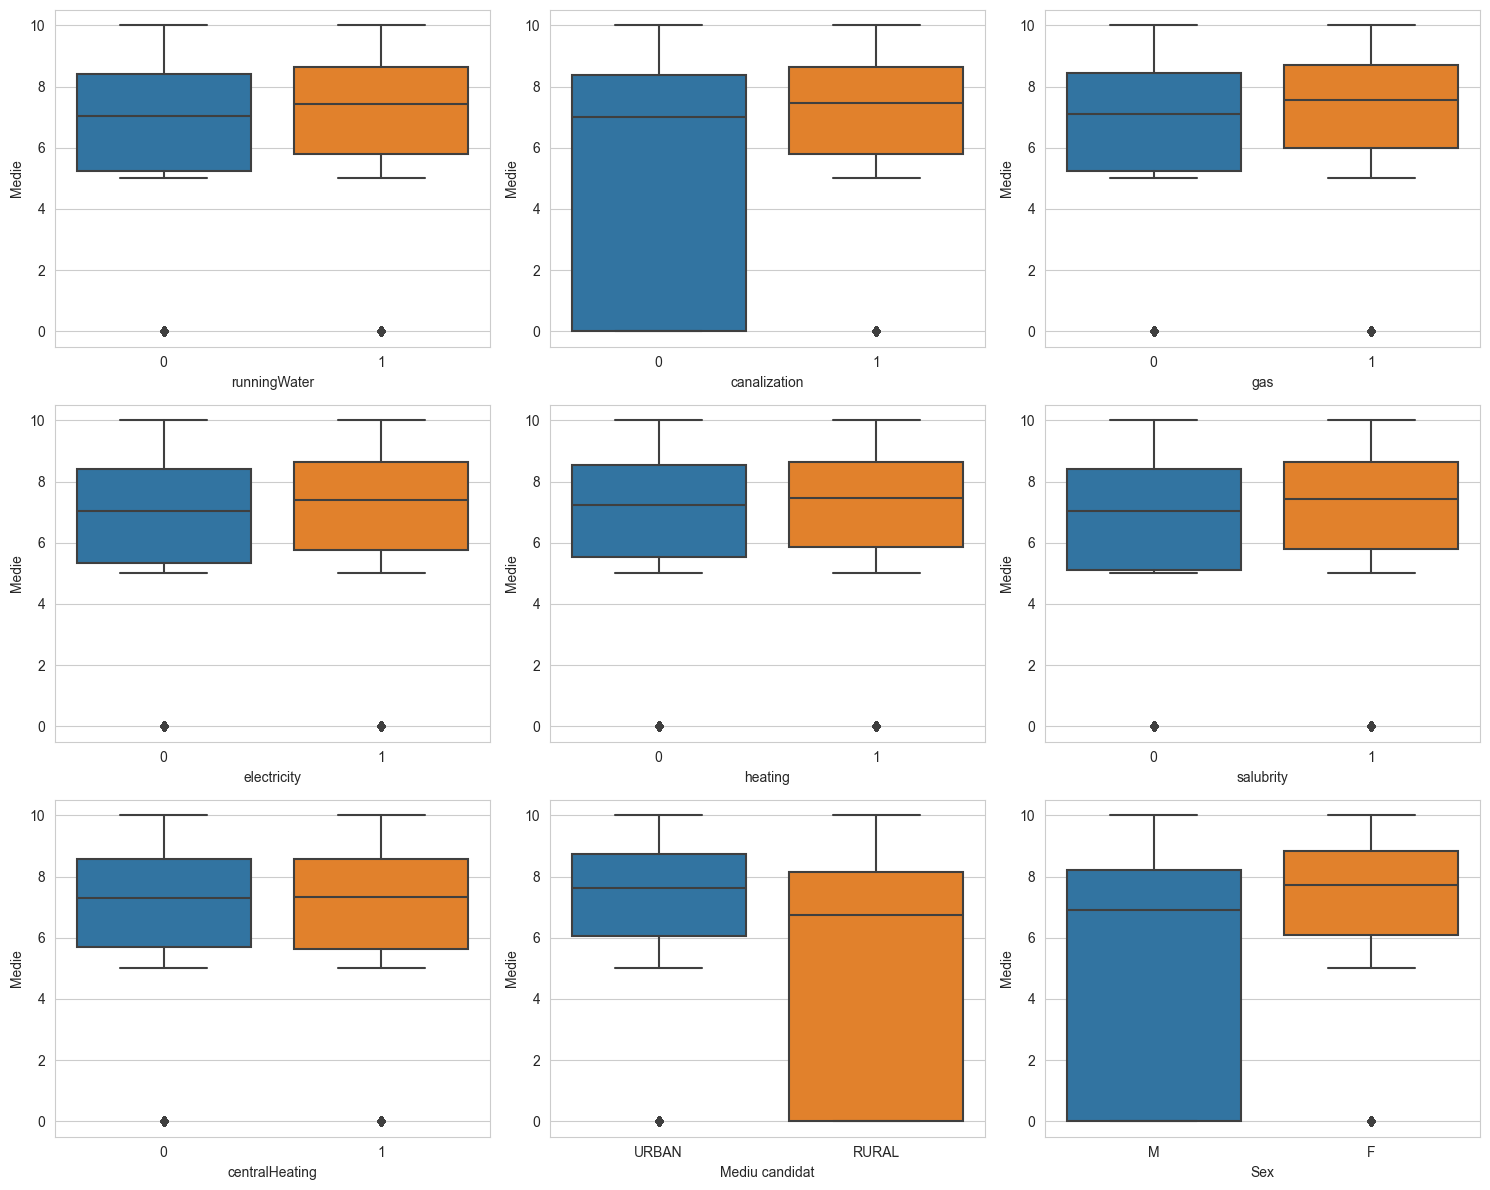

In [6]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# List of facility-related columns
facility_columns = ['runningWater', 'canalization', 'gas', 'electricity', 'heating', 'salubrity', 'centralHeating']

# Plotting the relationship between facilities and average score
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

# Plot each facility's impact on average scores by iterating through the list on a 3x3 panel
for i, column in enumerate(facility_columns + ['Mediu candidat', 'Sex']):
    row = i // 3 #calculates the row number where the plot shoud be placed by integer division
    col = i % 3 #calculates the column number where the plot shoud be placed by mod
    sns.boxplot(x=column, y='Medie', data=students_data, ax=axes[row, col])

plt.tight_layout()
plt.show()

### Facilities
**Running Water, Canalization, Gas, Electricity, Heating, Salubrity, Central Heating:** 
There seems to be a variation in average scores based on the presence of certain facilities. For example, schools with central heating, canalization, and running water tend to have higher average scores. This suggests that these facilities might be contributing positively to the students' academic performance.

### Environment
**Mediu Candidat:** 
There's a noticeable difference in average scores between different environments, likely distinguishing between urban and rural settings. This indicates that the environmental setting of the school could be an important factor in student performance.

### Gender
**Sex:** 
The boxplots show some differences in performance between genders, which might be an important factor to consider.

Given these insights, a simple statistical model could be built to predict students' average scores based on these factors. We could use a linear regression model as it's well-suited for predicting a continuous outcome (like average scores) based on multiple independent variables.

Before building the model, we will run a check for multicollinearity among the independent variables, as highly correlated predictors can distort the model's results.

In [11]:
# We are using one-hot encoding for categorical variables 'Sex' and 'Mediu candidat' because linear models require numerical input
students_data_encoded = pd.get_dummies(students_data, columns=['Sex', 'Mediu candidat'])
model_features = facility_columns + ['Sex_M', 'Mediu candidat_URBAN']

# Filtering the DataFrame for the features to be used in the model
X = students_data_encoded[model_features]

# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

vif_data.sort_values(by="VIF", ascending=False)

,feature,VIF
0,runningWater,55.899832
3,electricity,37.230504
1,canalization,33.303784
5,salubrity,21.813217
6,centralHeating,4.320058
2,gas,3.197866
4,heating,2.695522
8,Mediu candidat_URBAN,2.119753
7,Sex_M,1.666736


### A VIF value greater than 10 suggests significant multicollinearity

 Facilities like running water, electricity, and canalization have high VIF values (above 10)

 Other variables like gas, heating, salubrity, central heating, urban environment (Mediu candidat_URBAN), and gender (Sex_M) have lower VIF values

In [17]:
# Selecting a subset of variables to reduce multicollinearity
selected_features = ['centralHeating', 'Sex_M', 'Mediu candidat_URBAN']

# We sum up all facility-related features to create a single composite score to reduce multicollinearity (as these features are correlated)
# and still captures the overall facility level of a school
students_data_encoded['combined_facilities'] = students_data_encoded[facility_columns].sum(axis=1)
selected_features.append('combined_facilities')

# X_model holds independent variables and y_model is the dependent variable
X_model = students_data_encoded[selected_features]
y_model = students_data_encoded['Medie']

# Splitting the dataset into training and testing sets (70/30)
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.3, random_state=42)

# Creating and fitting the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predicting and evaluating the model
y_pred = lr_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

rmse, r2

(3.335576233388615, 0.04879047136328729)

# Results Interpretation

### The low R² value suggests that the factors we included in the model do not have a strong linear relationship with the average scores, as only about 4.9% of the variation in students' average scores can be explained by the variables included in this model

### As a perspective of improving this model, I think we should add external factors that are not included in our dataset (such as individual student's characteristics, quality of teaching, etc)

### A RMSE value of ~3.34 is signifiant for a scale of refference from 1 to 10, which indicated high inaccuracy